<a href="https://colab.research.google.com/github/mai0elkady/flower_classifier/blob/master/notebooks/scratch_Figure2_Replication_Modified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd gdrive/My Drive/discrete_flows/PyTorchDiscreteFlows/
# this contains code cloned from: https://github.com/TrentBrick/PyTorchDiscreteFlows

/content/gdrive/My Drive/discrete_flows/PyTorchDiscreteFlows


In [3]:
from platform import python_version

print(python_version())
STATE_PATH = 'checkpoint_for_training.pth'

3.6.9


Parts of this notebook are taken from Andre Karpathy: https://github.com/karpathy/pytorch-normalizing-flows/blob/master/nflib1.ipynb
and have been modified. 

Using the Embedding rather than an MLP was acknowledged by Jan Francu and Yashas Annadani who I am grateful to. 

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import figure
from matplotlib.backends import backend_agg
from scipy.stats import multivariate_normal
import torch
import itertools
import random
import os
print(np.__version__)
print(torch.__version__)

1.18.5
1.7.0+cu101


In [5]:
# importing all of the normalizing flows. 
import discrete_flows.disc_utils 
from discrete_flows.made import MADE
from discrete_flows.mlp import MLP
from discrete_flows.embed import EmbeddingLayer
from discrete_flows.disc_models import *

In [6]:
# will autoupdate any of the packages imported:
%load_ext autoreload
%autoreload 2

In [7]:
seed = 42
test_exp_paper = 1
use_flows = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
np.random.seed(seed)  # Numpy module.
random.seed(seed)  # Python random module.
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
os.environ['PYTHONHASHSEED'] = str(seed)

##Generating the training data. According to 4.1 in the DF paper.
Storing the data as variable "data" which will then be sampled from.

In [8]:
def create_syn_data_paper(k,d,n_samples,rnd_seed):
  np.random.seed(rnd_seed)
  orig_probs = np.random.dirichlet(np.ones(k**d))
  X_train_coded = np.random.choice(k**d, size=n_samples, p=orig_probs) #for k=2 and d=2, X_train_coded = {0,1,2,3,2,3,0,...}
  return orig_probs,X_train_coded


# Create binary matrix from integer values
def get_possible(n_features):
    k = 2
    y_possible = np.arange(n_features**k)
    possible_values = np.unpackbits(y_possible.astype(np.uint8).reshape(-1, 1), axis=1)
    possible_values = possible_values[:, -n_features:] # Remove extra zero columns
    return possible_values
    
def dec_to_bin(data,n_features):
  possible_bin_values = get_possible(n_features)
  result = possible_bin_values[data]
  return np.array(result)


In [9]:
def calculate_joint(data):
  alpha = 10**(-6)
  n,d = data.shape
  possible_values = get_possible(n_features=d)
  joint_p = {}

  for item in data:
    if tuple(item.tolist()) in joint_p:
      joint_p[tuple(item.tolist())] += 1
    else:
      joint_p[tuple(item.tolist())] = 1
  print(joint_p)
  s = sum(joint_p.values()) + 2*alpha
  p_joint = []
  for possible_value in possible_values:
    if(tuple(possible_value) in joint_p):
      p_joint.append((joint_p[tuple(possible_value)]+alpha)/s)
    else:
      p_joint.append(alpha/s)
  return p_joint

In [10]:
if(test_exp_paper == 1):
  nsamples = 10000
  k = 2
  d = 2
  orig_probs,X_train_coded = create_syn_data_paper(k,d,nsamples,seed)
  data = torch.from_numpy(dec_to_bin(X_train_coded,d))
  batch_size = 1024
  vocab_size = k
  sequence_length = d
  calculate_joint(data)
  print(orig_probs)

{(0, 1): 5351, (0, 0): 853, (1, 1): 1537, (1, 0): 2259}
[0.08219683 0.52725178 0.2306407  0.15991069]


In [11]:
def sample_batch_size_data(data,batch_size):
  n,d = data.shape
  chosen_indices = np.random.choice(n,batch_size,replace=False)
  return data[chosen_indices,:]
sample_batch_size_data(data,10)

tensor([[0, 1],
        [1, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 1]], dtype=torch.uint8)

## Generating the training data. A 2D Mixture of 8 Gaussians. 
Storing the data as variable "data" which will then be sampled from. 

In [12]:
def sample_quantized_gaussian_mixture(batch_size):
    """Samples data from a 2D quantized mixture of Gaussians.
    This is a quantized version of the mixture of Gaussians experiment from the
    Unrolled GANS paper (Metz et al., 2017).
    Args:
        batch_size: The total number of observations.
    Returns:
        Tensor with shape `[batch_size, 2]`, where each entry is in
            `{0, 1, ..., max_quantized_value - 1}`, a rounded sample from a mixture
            of Gaussians.
    """
    clusters = np.array([[2., 0.], [np.sqrt(2), np.sqrt(2)],
                                             [0., 2.], [-np.sqrt(2), np.sqrt(2)],
                                             [-2., 0.], [-np.sqrt(2), -np.sqrt(2)],
                                             [0., -2.], [np.sqrt(2), -np.sqrt(2)]])
    assignments = torch.distributions.OneHotCategorical(
            logits=torch.zeros(8, dtype = torch.float32)).sample([batch_size])
    means = torch.matmul(assignments, torch.from_numpy(clusters).float())

    samples = torch.distributions.normal.Normal(loc=means, scale=0.1).sample()
    clipped_samples = torch.clamp(samples, -2.25, 2.25)
    quantized_samples = (torch.round(clipped_samples * 20) + 45).long()
    return quantized_samples

In [13]:
if(test_exp_paper == 0):
  batch_size, sequence_length, vocab_size = 1024, 2, 91
  data = sample_quantized_gaussian_mixture(batch_size)

tensor([1, 1, 0,  ..., 1, 1, 1], dtype=torch.uint8)


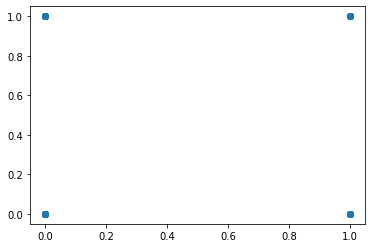

In [14]:
print(data[:,1])
plt.scatter(data[:,0],data[:,1])

(array([[ 853., 5351.],
       [2259., 1537.]]), [array([0. , 0.5, 1. ]), array([0. , 0.5, 1. ])])
[0.0853 0.5351]
[0.2259 0.1537]
[[0.0853 0.5351]
 [0.2259 0.1537]]


Text(0.5, 1.0, 'Data Distribution')

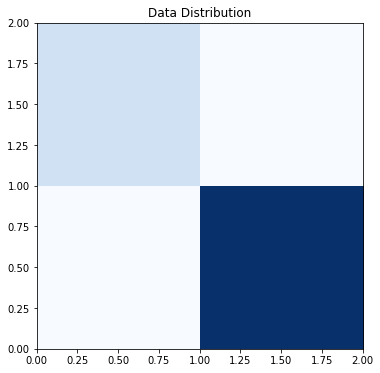

In [15]:
np.set_printoptions(precision=8)
figsize = (6, 6)
fig = fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(1,1,1)
#canvas = backend_agg.FigureCanvasAgg(fig)
data_prob_table = np.histogramdd(data, bins=vocab_size)
print(data_prob_table)
print((data_prob_table[0]/np.sum(data_prob_table[0]))[0])
print((data_prob_table[0]/np.sum(data_prob_table[0]))[1])
print(data_prob_table[0]/np.sum(data_prob_table[0]))
ax.imshow(data_prob_table[0]/np.sum(data_prob_table[0]),
             cmap=cm.get_cmap("Blues", 6),
             origin="lower",
             extent=[0, vocab_size, 0, vocab_size],
             interpolation="nearest")
#fig.show()
ax.set_title("Data Distribution")

## Generating the model

In [16]:
num_flows = 1 # number of flow steps. This is different to the number of layers used inside each flow
temperature = 0.1 # used for the straight-through gradient estimator. Value taken from the paper
disc_layer_type = 'autoreg' #'autoreg' #'bipartite'

# This setting was previously used for the MLP and MADE networks. 
nh = 8 # number of hidden units per layer
vector_length = sequence_length*vocab_size #here seq len is 2, vocab size is 91

In [17]:
flows = []
for i in range(num_flows):
    if disc_layer_type == 'autoreg':
        
        #layer = EmbeddingLayer([batch_size, sequence_length, vocab_size], output_size=vocab_size)
        # MADE network is much more powerful. Masked autoregressive flow
        layer = MADE([batch_size, sequence_length, vocab_size], vocab_size, [nh, nh, nh])
        
        disc_layer = DiscreteAutoregressiveFlow( layer, temperature, 
                                                    vocab_size )
    
    elif disc_layer_type == 'bipartite':
        # MLP will learn the factorized distribution and not perform well. 
        #layer = MLP(vector_length//2, vector_length//2, nh)
        
        layer = torch.nn.Embedding(vector_length//2, vector_length//2)
        
        disc_layer = DiscreteBipartiteFlow(layer, i%2, temperature, 
                                            vocab_size, vector_length, embedding=True)
        # i%2 flips the parity of the masking. It splits the vector in half and alternates
        # each flow between changing the first half or the second. 
    
    flows.append(disc_layer)
if(use_flows == 1):  
  model = DiscreteAutoFlowModel(flows)
  print(model)
else:
  if(disc_layer_type=='autoreg'):
    model = MADE([batch_size, sequence_length, vocab_size], vocab_size, [nh, nh, nh])
    print(model)

DiscreteAutoFlowModel(
  (flows): ModuleList(
    (0): DiscreteAutoregressiveFlow(
      (layer): MADE(
        (network): Sequential(
          (0): MaskedLinear(in_features=4, out_features=8, bias=True)
          (1): ReLU()
          (2): MaskedLinear(in_features=8, out_features=8, bias=True)
          (3): ReLU()
          (4): MaskedLinear(in_features=8, out_features=4, bias=True)
        )
      )
    )
  )
)


## Making random base probability distribution

tensor([[-0.0716, -0.0909],
        [-1.3297, -0.5426]], requires_grad=True)
tensor([[[1., 0.],
         [0., 1.]],

        [[0., 1.],
         [1., 0.]],

        [[1., 0.],
         [0., 1.]],

        ...,

        [[0., 1.],
         [0., 1.]],

        [[1., 0.],
         [0., 1.]],

        [[0., 1.],
         [0., 1.]]])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


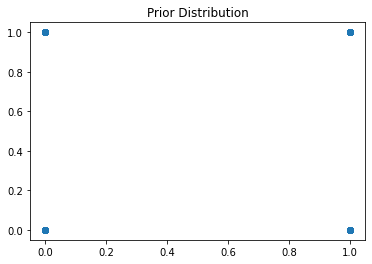

In [18]:
base_log_probs = torch.tensor(torch.randn(sequence_length, vocab_size), requires_grad = True)
print(base_log_probs)
base = torch.distributions.OneHotCategorical(logits = base_log_probs)
samps = base.sample((10000,)).argmax(-1)
print(base.sample((10000,)))
plt.scatter(samps[:,0], samps[:,1], alpha=0.3)
plt.title("Prior Distribution")
plt.show()

## Fit model. 
NB. A local minima (loss value around 7.3 is learning the factorized distribution). Global optima is somewhere around 6.7. May need to reset the model and base probability distribution in the above cells a few times to get a good result. 

In [19]:
data.type()
data = data.type(torch.int64)
print(data.type())

torch.LongTensor


In [20]:
model.state_dict


<bound method Module.state_dict of DiscreteAutoFlowModel(
  (flows): ModuleList(
    (0): DiscreteAutoregressiveFlow(
      (layer): MADE(
        (network): Sequential(
          (0): MaskedLinear(in_features=4, out_features=8, bias=True)
          (1): ReLU()
          (2): MaskedLinear(in_features=8, out_features=8, bias=True)
          (3): ReLU()
          (4): MaskedLinear(in_features=8, out_features=4, bias=True)
        )
      )
    )
  )
)>

A new minimum loss is achieved, saving the model's state
epoch: 0 loss: 1.2446712255477905
A new minimum loss is achieved, saving the model's state
A new minimum loss is achieved, saving the model's state


/content/gdrive/My Drive/discrete_flows/PyTorchDiscreteFlows/discrete_flows/disc_utils.py:119: UserWarning: The function torch.fft is deprecated and will be removed in PyTorch 1.8. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.fftn. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:567.)
  inputs_fft = torch.fft(inputs, 1) #ignore last and first dimension to do batched fft
/content/gdrive/My Drive/discrete_flows/PyTorchDiscreteFlows/discrete_flows/disc_utils.py:124: UserWarning: The function torch.ifft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.ifftn. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:578.)
  return torch.ifft(result_fft, 1)[...,0] #return only the real part


A new minimum loss is achieved, saving the model's state
A new minimum loss is achieved, saving the model's state
A new minimum loss is achieved, saving the model's state
A new minimum loss is achieved, saving the model's state
A new minimum loss is achieved, saving the model's state
A new minimum loss is achieved, saving the model's state
A new minimum loss is achieved, saving the model's state
A new minimum loss is achieved, saving the model's state
epoch: 150 loss: 1.2149980068206787
epoch: 300 loss: 1.2221366167068481
epoch: 450 loss: 1.2276865243911743
A new minimum loss is achieved, saving the model's state
A new minimum loss is achieved, saving the model's state
epoch: 600 loss: 1.1640568971633911
A new minimum loss is achieved, saving the model's state
epoch: 750 loss: 1.2108252048492432
epoch: 900 loss: 1.2263269424438477
epoch: 1050 loss: 1.241919755935669
epoch: 1200 loss: 1.1885859966278076
epoch: 1350 loss: 1.1930463314056396
tensor(1.2243, grad_fn=<DivBackward0>)


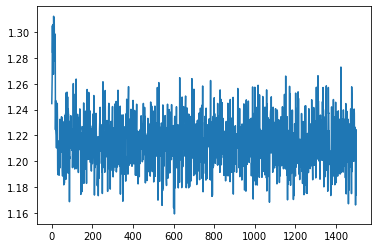

In [21]:
epochs = 1500
learning_rate = 0.01
print_loss_every = epochs//10
min_loss =  10**6
losses = []
optimizer = torch.optim.Adam( 
        [
            {'params': model.parameters() , 'lr':learning_rate},
            {'params': base_log_probs, 'lr': learning_rate }
        ])

model.train()
for e in range(epochs):
    if(test_exp_paper == 0):
      x = sample_quantized_gaussian_mixture(batch_size)
    else:
      x = sample_batch_size_data(data,batch_size)
    x = F.one_hot(x, num_classes = vocab_size).float()

    if disc_layer_type == 'bipartite':
        x= x.view(x.shape[0], -1) #flattening vector


    optimizer.zero_grad()
    zs = model.forward(x)
   
    if disc_layer_type == 'bipartite':
        zs = zs.view(batch_size, sequence_length, -1) # adding back in sequence dimension

    base_log_probs_sm = torch.nn.functional.log_softmax(base_log_probs, dim=-1)

    #print(zs.shape, base_log_probs_sm.shape)
    logprob = zs*base_log_probs_sm # zs are onehot so zero out all other logprobs 
    
    loss = -torch.sum(logprob)/batch_size
    if(loss<min_loss):
      print("A new minimum loss is achieved, saving the model's state")
      min_loss = loss
      torch.save({
            'epoch': e,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss}, STATE_PATH)
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if e%print_loss_every==0:
        print('epoch:', e, 'loss:', loss.item())
print(loss)
plt.plot(losses)

In [22]:
print("Loading the model's state that achieved minimum loss")
model = DiscreteAutoFlowModel(flows)
optimizer = torch.optim.Adam( 
        [
            {'params': model.parameters() , 'lr':learning_rate},
            {'params': base_log_probs, 'lr': learning_rate }
        ])

checkpoint = torch.load(STATE_PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
model.eval()
print("This corresponded to a loss of "+str(loss.item())+" at epoch "+str(epoch))

Loading the model's state that achieved minimum loss
This corresponded to a loss of 1.159274935722351 at epoch 604


tensor([[0.6327, 0.3673],
        [0.2420, 0.7580]], grad_fn=<SoftmaxBackward>)
Shape of data samples
(1024, 2)
Example of data samples
[[0 0]
 [1 0]
 [0 0]
 [1 0]
 [1 1]
 [1 0]
 [1 1]
 [0 0]
 [0 0]
 [1 1]]
Probability table from original data
[[0.08219683 0.52725178]
 [0.2306407  0.15991069]]
Learned joint Probability table using flows
[[0.15820312 0.484375  ]
 [0.26660156 0.09082031]]
Learned joint Probability table not using flows
[[0.0853 0.5351]
 [0.2259 0.1537]]
Learned Probability table from Marginals
[[0.2729702  0.36960793]
 [0.15183449 0.20558739]]
Learned Probability table from Marginals not using flows
[[0.19306848 0.42733152]
 [0.11813152 0.26146848]]


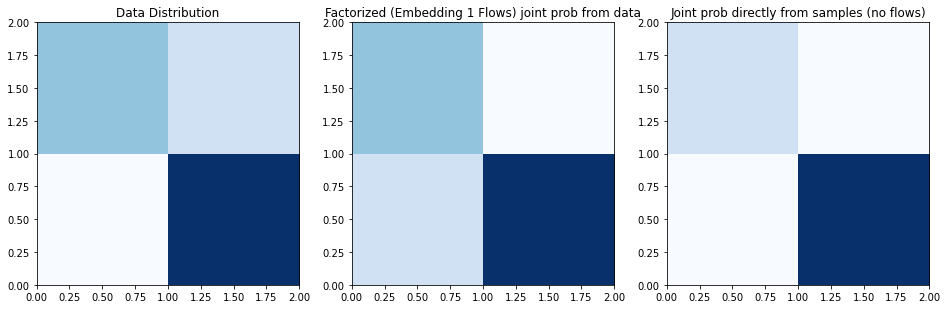

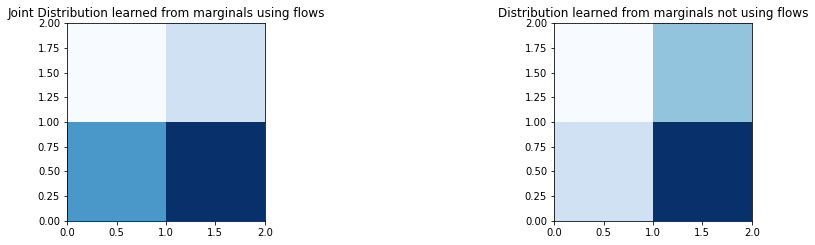

In [23]:

data_distribution = torch.distributions.OneHotCategorical(logits=base_log_probs)
print(data_distribution.probs)
samples = data_distribution.sample([batch_size])
if disc_layer_type == 'bipartite':
    samples = samples.view(samples.shape[0], -1)
samples = model.reverse(samples)
if disc_layer_type == 'bipartite':
    samples = samples.view(batch_size, sequence_length, -1)
data_samples = torch.argmax(samples, axis=-1).detach().numpy()
print("Shape of data samples")
print(data_samples.shape)
print("Example of data samples")
print(data_samples[0:10,:])
figsize = (16, 8)
fig = plt.figure(figsize=figsize)
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)
fig2 = plt.figure(figsize=figsize)
ax4 = fig2.add_subplot(2, 2, 1)
ax5 = fig2.add_subplot(2, 2, 2)
data_prob_table = np.histogramdd(data, bins=vocab_size)
print("Probability table from original data")
orig_probs_arr = np.array([orig_probs[0:2],orig_probs[2:]])
print(orig_probs_arr)
ax1.imshow(orig_probs_arr,
         cmap=cm.get_cmap("Blues", 6),
         origin="lower",
         extent=[0, vocab_size, 0, vocab_size],
         interpolation="nearest")
ax1.set_title("Data Distribution")
ax2.set_title("{} ({} {} Flows) joint prob from data".format(
  "factorized".replace("_", " ").title(),
  "embedding".title(),
  num_flows))

learned_prob_table = np.histogramdd(data_samples, bins=vocab_size)
print("Learned joint Probability table using flows")
joint_prob_flows = learned_prob_table[0]/np.sum(learned_prob_table[0])
print(joint_prob_flows)
ax2.imshow(joint_prob_flows,
         cmap=cm.get_cmap("Blues", 6),
         origin="lower",
         extent=[0, vocab_size, 0, vocab_size],
         interpolation="nearest")
fig.show()
plt.gcf().savefig('figures/Fig2Reproduce.png', dpi=250)

ax3.set_title("Joint prob directly from samples (no flows)")
learned_prob_table = np.histogramdd(data, bins=vocab_size)
print("Learned joint Probability table not using flows")
joint_prob_no_flows = learned_prob_table[0]/np.sum(learned_prob_table[0])
print(joint_prob_no_flows)
ax3.imshow(joint_prob_no_flows,
         cmap=cm.get_cmap("Blues", 6),
         origin="lower",
         extent=[0, vocab_size, 0, vocab_size],
         interpolation="nearest")
fig.show()

#learned probability by marginals
[p_x1_1,p_x2_1]=np.mean(data_samples,axis = 0)
vec1 = [1-p_x1_1,p_x1_1]
vec2 = [1-p_x2_1,p_x2_1]
learned_prob_from_marginals_flows = np.outer(vec1,vec2)
print("Learned Probability table from Marginals")
print(learned_prob_from_marginals_flows)
ax4.imshow(learned_prob_from_marginals_flows,
         cmap=cm.get_cmap("Blues", 6),
         origin="lower",
         extent=[0, vocab_size, 0, vocab_size],
         interpolation="nearest")
ax4.set_title("Joint Distribution learned from marginals using flows")
fig2.show()

#learned probability by marginals
[p_x1_1,p_x2_1]=np.mean(data.numpy(),axis = 0)
vec1 = [1-p_x1_1,p_x1_1]
vec2 = [1-p_x2_1,p_x2_1]
learned_prob_from_marginals_no_flows = np.outer(vec1,vec2)
print("Learned Probability table from Marginals not using flows")
print(learned_prob_from_marginals_no_flows)

ax5.imshow(learned_prob_from_marginals_no_flows,
         cmap=cm.get_cmap("Blues", 6),
         origin="lower",
         extent=[0, vocab_size, 0, vocab_size],
         interpolation="nearest")
ax5.set_title("Distribution learned from marginals not using flows")
fig2.show()
plt.gcf().savefig('figures/Fig2Reproduce.png', dpi=250)

In [24]:
def kl_divergence(p, q):
	return sum(p[i] * np.log(p[i]/q[i]) for i in range(len(p)))
#orig_probs the probablities we used for generating the data
#flatten the learned probabilities by row

kl1 = kl_divergence(orig_probs,joint_prob_flows.flatten())
kl2 = kl_divergence(orig_probs,joint_prob_no_flows.flatten())
print("kl divergence between original probabilities and joint probs learned using flows is "+str(kl1))
print("kl divergence between original probabilities and joint probs learned not using flows is "+str(kl2))
kl3 = kl_divergence(orig_probs,learned_prob_from_marginals_flows.flatten())
kl4 = kl_divergence(orig_probs,learned_prob_from_marginals_no_flows.flatten())
print("kl divergence between original probabilities and the calculated joint prob from the marginals using flows is "+str(kl3))
print("kl divergence between original probabilities and the calculated joint prob from the marginals not using flows is "+str(kl4))


kl divergence between original probabilities and joint probs learned using flows is 0.04794959164205843
kl divergence between original probabilities and joint probs learned not using flows is 0.0002882037075050189
kl divergence between original probabilities and the calculated joint prob from the marginals using flows is 0.14488759444466948
kl divergence between original probabilities and the calculated joint prob from the marginals not using flows is 0.11628018334494816
